<a href="https://colab.research.google.com/github/divyanshuraj6815/eva/blob/master/Experiment%2013/Experiment_13_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#call heavenly Gods
import time
import keras
import numpy as np
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras import layers, models
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
counter = 3

def resnet_18 (x):
  def add_common_layers (y, name):
    y = layers.BatchNormalization (name = name + '_bn')(y)
    y = layers.Activation ('relu', name = name + '_relu')(y)
    return y
  
  def add (y, name):
    y = layers.add (y, name = name + '_add')
    return y
  
  def conv (y, channel_size, kernel_size, stride, name):
    global counter
    if counter % 2 == 0:
      y = add_common_layers (y, name)
    y = layers.Conv2D (channel_size, (kernel_size, kernel_size), strides = stride, padding = 'same', name = name + '_conv_' + str (counter), kernel_regularizer=regularizers.l2(0.0005))(y)
    counter += 1
    return (y)
  
  def residual (y, channel_size, kernel_size, name, do_max_pool = False):
    global counter
    if do_max_pool == False:
      residue = conv (y, channel_size, kernel_size, 1, name + '_residue_1')
      #y = layers.Conv2D (channel_size, (1, 1), name = name + '_original')(y)
    else:
      residue = conv (y, channel_size, kernel_size, 2, name + '_residue_1')
      y = layers.Conv2D (channel_size, (1, 1), strides = 2, name = name + '_original_reshaped')(y)

    residue = conv (residue, channel_size, kernel_size, 1, name + '_residue_2')
    y = add ([y, residue], name + '_1')
    y = add_common_layers (y, name + '_1')
    
    residue = conv (y, channel_size, kernel_size, 1, name + '_residue_3')
    residue = conv (residue, channel_size, kernel_size, 1, name + '_residue_4')
    y = add ([y, residue], name + '_2')
    if counter != 19:
      y = add_common_layers (y, name + '_2')
    
    return y
  
  x = layers.Conv2D (64, (3, 3), strides = 1, padding='same', name='first_layer_112_1')(x)
  #x = layers.Conv2D (64, (3, 3), strides = 2, padding='same', name='second_layer_56_2')(x)
  x = add_common_layers (x, 'preparation')

  x = residual (x, 64, 3, 'B1')
  x = residual (x, 128, 3, 'B2', True)
  x = residual (x, 256, 3, 'B3', True)
  x = residual (x, 512, 3, 'B4', True)
  
  maxpool = layers.MaxPooling2D((4, 4))(x)
  avgPool = layers.AveragePooling2D ((4, 4))(x)
  
  x = layers.concatenate ([maxpool, avgPool])
  x = layers.Conv2D (10, 1, name = 'linear')(x)
  x = layers.Flatten ()(x)

  x = layers.Activation ('softmax')(x)
  return x


In [0]:
#define global parameters
img_width = 32
img_height = 32
img_channels = 3

image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = resnet_18 (image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
first_layer_112_1 (Conv2D)      (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
preparation_bn (BatchNormalizat (None, 32, 32, 64)   256         first_layer_112_1[0][0]          
__________________________________________________________________________________________________
preparation_relu (Activation)   (None, 32, 32, 64)   0           preparation_bn[0][0]             
_______________________________________________________________________________

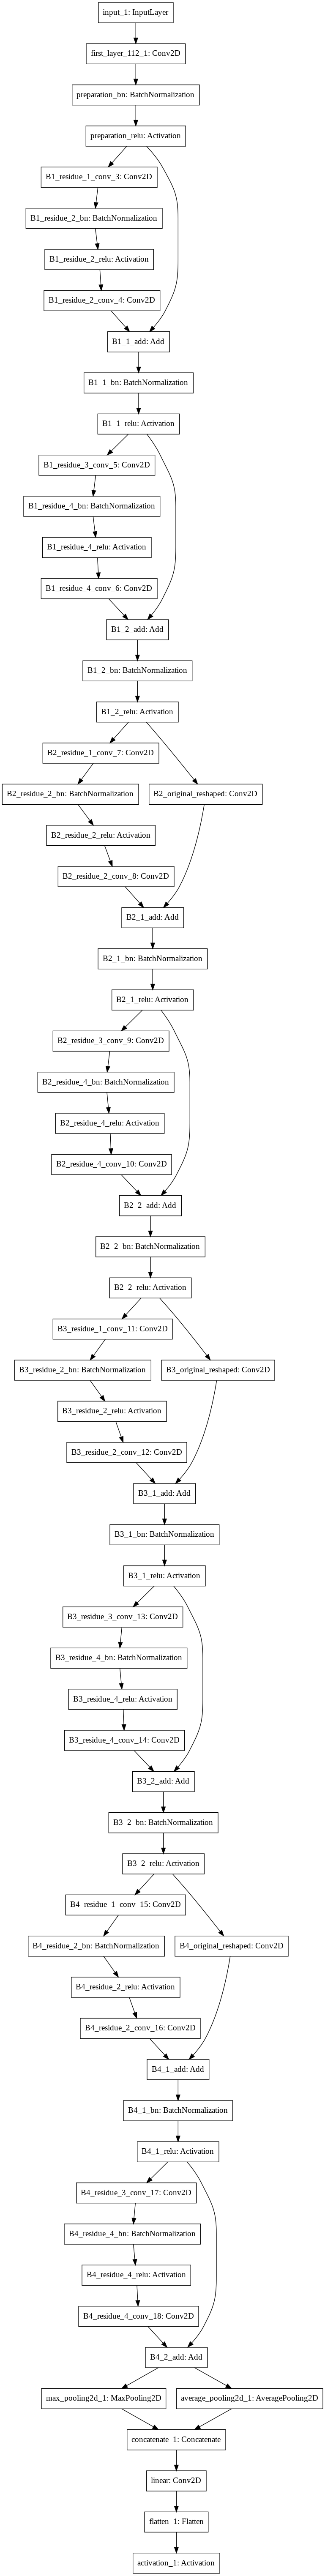

In [0]:
plot_model(model)


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(50000, 1)


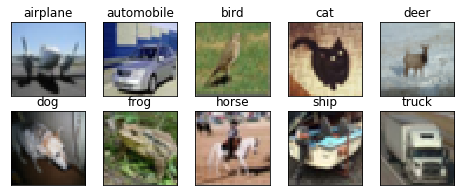

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
print (train_features.shape)
print (train_labels.shape)
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
for_heatmap_plot = dict ()
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    for_heatmap_plot[ class_names[i] ] = train_features[idx]
    plt.imshow(im)
plt.show()

train_features = train_features.astype('float32')/255
#print (train_features[0][0][0][1])
train_features[:,:,:,0] = (train_features[:,:,:,0] - 0.4914) / 0.2023
train_features[:,:,:,1] = (train_features[:,:,:,1] - 0.4822) / 0.1994
train_features[:,:,:,2] = (train_features[:,:,:,2] - 0.4465) / 0.2010

#print (train_features[0][0][0][1])
test_features = test_features.astype('float32')/255
test_features[:,:,:,0] = (test_features[:,:,:,0] - 0.4914) / 0.2023
test_features[:,:,:,1] = (test_features[:,:,:,1] - 0.4822) / 0.1994
test_features[:,:,:,2] = (test_features[:,:,:,2] - 0.4465) / 0.2010
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)
print (train_features.shape)
print (test_features.shape)

In [0]:
def pad_with(vector, pad_width, iaxis, kwargs):
  pad_value = kwargs.get('padder', 10)
  vector[:pad_width[0]] = pad_value
  vector[-pad_width[1]:] = pad_value
  
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        c = [input_img[:,:,0].mean (), input_img[:,:,1].mean (), input_img[:,:,2].mean ()]
        #print (c)
        #c = [0,0,0]
        img = np.zeros ((40, 40, 3))
        img[:,:,0] = np.pad (input_img[:,:,0], 4, pad_with, padder=c[0])
        img[:,:,1] = np.pad (input_img[:,:,1], 4, pad_with, padder=c[1])
        img[:,:,2] = np.pad (input_img[:,:,2], 4, pad_with, padder=c[2])
        
        assert img.shape[2] == 3
        height, width = img.shape[0], img.shape[1]
        dy, dx = (32, 32)
        x = np.random.randint(0, width - dx + 1)
        y = np.random.randint(0, height - dy + 1)
        input_img = img[y:(y+dy), x:(x+dx), :]
        return input_img

        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        input_img[top:top + h, left:left + w, 0] = c[0]
        input_img[top:top + h, left:left + w, 1] = c[1]
        input_img[top:top + h, left:left + w, 2] = c[2]

        return input_img

    return eraser

In [0]:
from keras.callbacks import Callback
from keras import backend as K
import numpy as np


class CyclicLR (Callback):
    def __init__(
            self,
            base_lr=0.001,
            max_lr=1,
            step_size=2000,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def optimized_clr (self):
      if self.clr_iterations > (2 * self.step_size):
        temp_step = self.step_size / 4
        cycle = np.floor(1 + self.clr_iterations / (2 * temp_step))
        x = np.abs(self.clr_iterations / temp_step - 2 * cycle + 1)
        return self.base_lr - (self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
      else:
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
      
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.optimized_clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
clr = CyclicLR(
	mode='triangular',
	base_lr=0.005,
	max_lr=0.1,
	step_size= 20 * (train_features.shape[0] // 128))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=50)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
390/390 [==============================] - 130s 333ms/step - loss: 3.7629 - acc: 0.2991 - val_loss: 3.5304 - val_acc: 0.3740

Epoch 00001: val_acc improved from -inf to 0.37400, saving model to weights-0.374000.hdf5
Epoch 2/50
390/390 [==============================] - 123s 314ms/step - loss: 3.3327 - acc: 0.4373 - val_loss: 3.2411 - val_acc: 0.4714

Epoch 00002: val_acc improved from 0.37400 to 0.47140, saving model to weights-0.471400.hdf5
Epoch 3/50
390/390 [==============================] - 124s 318ms/step - loss: 3.1258 - acc: 0.5054 - val_loss: 3.0551 - val_acc: 0.5274

Epoch 00003: val_acc improved from 0.47140 to 0.52740, saving model to weights-0.527400.hdf5
Epoch 4/50
390/390 [==============================] - 125s 321ms/step - loss: 2.9335 - acc: 0.5649 - val_loss: 2.9363 - val_acc: 0.5577

Epoch 00004: val_acc improved from 0.52740 to 0.55770, saving model to weights-0

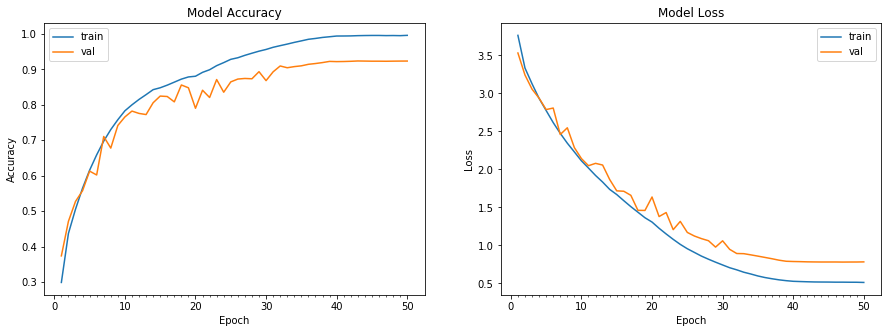

Accuracy on test data is: 92.34


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=0.5,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1))

filepath='weights-{val_acc:.6f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                callbacks=[clr, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

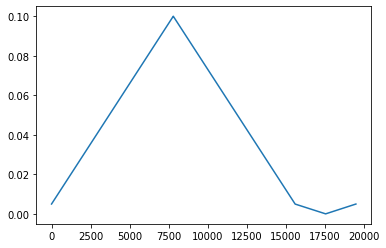

In [0]:
plt.plot(clr.history['iterations'], clr.history['lr'])

In [0]:
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 92.34
